**Step 1: Install required libraries**

In [1]:
pip install pandas pyarrow fastparquet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.3 MB/s eta 0:00:00


In [3]:
import pandas as pd

df = pd.read_parquet("train.parquet")
print(df.shape)
df.head()


(4500000, 19)


,city_id,store_id,management_group_id,first_category_id,second_category_id,third_category_id,product_id,dt,sale_amount,hours_sale,stock_hour6_22_cnt,hours_stock_status,discount,holiday_flag,activity_flag,precpt,avg_temperature,avg_humidity,avg_wind_level
0,0,0,0,5,6,65,38,2024-03-28,0.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, ...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,0,0,1.6999,15.48,73.54,1.97
1,0,0,0,5,6,65,38,2024-03-29,0.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, ...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,0,0,3.0190,15.08,76.56,1.71
2,0,0,0,5,6,65,38,2024-03-30,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0,2.0942,15.91,76.47,1.73
3,0,0,0,5,6,65,38,2024-03-31,0.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, ...",11,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...",1.0,1,0,1.5618,16.13,77.40,1.76
4,0,0,0,5,6,65,38,2024-04-01,0.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, ...",8,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1.0,0,0,3.5386,15.37,78.26,1.25


In [5]:
print(df.columns)


Index(['city_id', 'store_id', 'management_group_id', 'first_category_id',
       'second_category_id', 'third_category_id', 'product_id', 'dt',
       'sale_amount', 'hours_sale', 'stock_hour6_22_cnt', 'hours_stock_status',
       'discount', 'holiday_flag', 'activity_flag', 'precpt',
       'avg_temperature', 'avg_humidity', 'avg_wind_level'],
      dtype='object')


**Basic Cleaning**

In [6]:
df["dt"] = pd.to_datetime(df["dt"])

# Remove invalid sales
df = df[df["sale_amount"] >= 0]

# Fill missing values
df["discount"] = df["discount"].fillna(0)
df["holiday_flag"] = df["holiday_flag"].fillna(0)
df["activity_flag"] = df["activity_flag"].fillna(0)

df["precpt"] = df["precpt"].fillna(0)
df["avg_temperature"] = df["avg_temperature"].fillna(df["avg_temperature"].median())
df["avg_humidity"] = df["avg_humidity"].fillna(df["avg_humidity"].median())
df["avg_wind_level"] = df["avg_wind_level"].fillna(df["avg_wind_level"].median())


In [7]:
store_id = df["store_id"].unique()[0]
df = df[df["store_id"] == store_id]


In [8]:
products = df["product_id"].unique()[:100]
df = df[df["product_id"].isin(products)]


In [9]:
daily_df = (
    df.groupby([
        "store_id",
        "product_id",
        "first_category_id",
        "second_category_id",
        "third_category_id",
        "dt"
    ])
    .agg({
        "sale_amount": "sum",
        "discount": "mean",
        "holiday_flag": "max",
        "activity_flag": "max",
        "precpt": "mean",
        "avg_temperature": "mean",
        "avg_humidity": "mean",
        "avg_wind_level": "mean",
        "stock_hour6_22_cnt": "mean",
        "hours_stock_status": "mean"
    })
    .reset_index()
)


In [10]:
daily_df["day"] = daily_df["dt"].dt.day
daily_df["day_of_week"] = daily_df["dt"].dt.weekday
daily_df["week"] = daily_df["dt"].dt.isocalendar().week.astype(int)
daily_df["month"] = daily_df["dt"].dt.month
daily_df["is_weekend"] = daily_df["day_of_week"].isin([5, 6]).astype(int)


In [11]:
daily_df = daily_df.sort_values(["product_id", "dt"])

for lag in [1, 7, 14]:
    daily_df[f"lag_{lag}"] = (
        daily_df.groupby("product_id")["sale_amount"]
        .shift(lag)
    )


In [12]:
for window in [7, 14]:
    daily_df[f"rolling_mean_{window}"] = (
        daily_df.groupby("product_id")["sale_amount"]
        .shift(1)
        .rolling(window)
        .mean()
    )

    daily_df[f"rolling_std_{window}"] = (
        daily_df.groupby("product_id")["sale_amount"]
        .shift(1)
        .rolling(window)
        .std()
    )


In [13]:
daily_df["stockout_flag"] = (daily_df["stock_hour6_22_cnt"] < 1).astype(int)


In [14]:
daily_df = daily_df.dropna().reset_index(drop=True)


In [15]:
daily_df.to_csv("grocery_demand_ml_ready.csv", index=False)


**SARIMA TRAINING **

In [16]:
import pandas as pd
import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [17]:
# Load your processed daily dataset
df = pd.read_csv("grocery_demand_ml_ready.csv")

# Select ONE product (SKU)
product_id = df["product_id"].iloc[0]
sku_df = df[df["product_id"] == product_id].copy()

# Set datetime index
sku_df["dt"] = pd.to_datetime(sku_df["dt"])
sku_df = sku_df.sort_values("dt")
sku_df.set_index("dt", inplace=True)

y = sku_df["sale_amount"]


In [18]:
# Forecast horizon
HORIZON = 14

train = y.iloc[:-HORIZON]
test  = y.iloc[-HORIZON:]


In [19]:
model = SARIMAX(
    train,
    order=(1, 1, 1),              # ARIMA(p,d,q)
    seasonal_order=(1, 1, 1, 7),  # SARIMA(P,D,Q,s)
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = model.fit(disp=False)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [20]:
forecast = sarima_fit.forecast(steps=HORIZON)


In [26]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

mask = test != 0
mape = np.mean(np.abs((test[mask] - forecast[mask]) / test[mask])) * 100

smape = np.mean(
    2 * np.abs(forecast - test) / (np.abs(test) + np.abs(forecast))
) * 100

print(f"MAE   : {mae:.2f}")
print(f"RMSE  : {rmse:.2f}")
print(f"MAPE  : {mape:.2f}%")
print(f"sMAPE : {smape:.2f}%")


MAE   : 2.50
RMSE  : 2.91
MAPE  : 69.11%
sMAPE : 83.48%


In [22]:
result = pd.DataFrame({
    "date": test.index,
    "actual": test.values,
    "forecast": forecast.values
})

print(result.head())


        date  actual  forecast
0 2024-06-12     0.3  2.337235
1 2024-06-13     0.5  0.971944
2 2024-06-14     0.9  1.677978
3 2024-06-15     3.1  7.008987
4 2024-06-16     2.4  5.992366


In [23]:
results = []

for pid in df["product_id"].unique()[:10]:
    temp = df[df["product_id"] == pid].copy()
    temp["dt"] = pd.to_datetime(temp["dt"])
    temp = temp.sort_values("dt").set_index("dt")

    y = temp["sale_amount"]
    train, test = y[:-14], y[-14:]

    model = SARIMAX(
        train,
        order=(1,1,1),
        seasonal_order=(1,1,1,7),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    fit = model.fit(disp=False)
    pred = fit.forecast(14)

    results.append({
        "product_id": pid,
        "mae": mean_absolute_error(test, pred),
        "rmse": np.sqrt(mean_squared_error(test, pred))
    })

sarima_summary = pd.DataFrame(results)
print(sarima_summary)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

   product_id       mae      rmse
0           4  1.833138  2.280297
1           6  0.481457  0.573388
2          18  0.329070  0.441687
3          19  0.446157  0.543890
4          21  0.310354  0.392664
5          23  0.765321  0.922032
6          26  0.302866  0.385975
7          38  0.706398  1.107295
8          41  0.713957  0.863854
9          70  1.462223  1.689054


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [27]:
product_id = 18

temp = df[df["product_id"] == product_id].copy()
temp["dt"] = pd.to_datetime(temp["dt"])
temp = temp.sort_values("dt").set_index("dt")

y = temp["sale_amount"]

HORIZON = 14
train = y.iloc[:-HORIZON]
test  = y.iloc[-HORIZON:]

model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

fit = model.fit(disp=False)

forecast = fit.forecast(HORIZON)

prediction_df = pd.DataFrame({
    "date": test.index,
    "actual_sales": test.values,
    "predicted_sales": forecast.values
})

print(prediction_df)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


         date  actual_sales  predicted_sales
0  2024-06-12           0.6         0.311070
1  2024-06-13           0.0         0.339794
2  2024-06-14           0.2         0.816249
3  2024-06-15           1.3         0.614635
4  2024-06-16           0.6         0.811319
5  2024-06-17           0.5         0.073045
6  2024-06-18           0.2         0.327306
7  2024-06-19           0.5         0.376640
8  2024-06-20           0.4         0.399633
9  2024-06-21           0.9         0.886961
10 2024-06-22           0.7         0.634187
11 2024-06-23           2.0         0.884790
12 2024-06-24           0.4         0.114287
13 2024-06-25           0.7         0.392433


In [31]:
FORECAST_HORIZON = 14          # days
MIN_HISTORY_DAYS = 60          # minimum data needed per product


In [32]:
all_predictions = []
all_metrics = []

for pid in df["product_id"].unique():

    sku_df = df[df["product_id"] == pid].copy()
    sku_df = sku_df.sort_values("dt").set_index("dt")

    y = sku_df["sale_amount"]

    # Skip products with insufficient history
    if len(y) < MIN_HISTORY_DAYS + FORECAST_HORIZON:
        continue

    train = y.iloc[:-FORECAST_HORIZON]
    test  = y.iloc[-FORECAST_HORIZON:]

    try:
        model = SARIMAX(
            train,
            order=(1,1,1),
            seasonal_order=(1,1,1,7),
            enforce_stationarity=False,
            enforce_invertibility=False
        )

        fit = model.fit(disp=False)
        forecast = fit.forecast(FORECAST_HORIZON)

        # ---- Save predictions ----
        pred_df = pd.DataFrame({
            "product_id": pid,
            "date": test.index,
            "actual_sales": test.values,
            "predicted_sales": forecast.values
        })

        all_predictions.append(pred_df)

        # ---- Save metrics ----
        mae = mean_absolute_error(test, forecast)
        rmse = np.sqrt(mean_squared_error(test, forecast))

        all_metrics.append({
            "product_id": pid,
            "mae": mae,
            "rmse": rmse
        })

    except Exception as e:
        print(f"Skipped product {pid} due to error: {e}")


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

In [33]:
sarima_predictions = pd.concat(all_predictions).reset_index(drop=True)
print(sarima_predictions.head())


   product_id        date  actual_sales  predicted_sales
0           4  2024-06-12           0.3         2.337235
1           4  2024-06-13           0.5         0.971944
2           4  2024-06-14           0.9         1.677978
3           4  2024-06-15           3.1         7.008987
4           4  2024-06-16           2.4         5.992366


In [34]:
sarima_predictions["product_id"].nunique()


74

In [35]:
sarima_predictions.groupby("product_id").size()


,0
product_id,
4,14
6,14
18,14
19,14
21,14
...,...
796,14
806,14
810,14


In [36]:
sarima_predictions[sarima_predictions["product_id"] == 21]
sarima_predictions[sarima_predictions["product_id"] == 26]


,product_id,date,actual_sales,predicted_sales
84,26,2024-06-12,1.00,0.598879
85,26,2024-06-13,0.60,0.642695
86,26,2024-06-14,0.90,0.867972
87,26,2024-06-15,1.20,0.939682
88,26,2024-06-16,0.00,1.035347
89,26,2024-06-17,1.20,0.856781
90,26,2024-06-18,1.00,0.856839
91,26,2024-06-19,1.10,0.640787
92,26,2024-06-20,0.37,0.647331
93,26,2024-06-21,0.50,0.890370


In [37]:
sarima_predictions.to_csv("sarima_all_product_predictions.csv", index=False)

metrics_df = pd.DataFrame(all_metrics)
metrics_df.to_csv("sarima_product_metrics.csv", index=False)


**XGBOOST**

In [40]:
pip install xgboost


In [41]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.metrics import mean_absolute_error, mean_squared_error


In [42]:
df = pd.read_csv("grocery_demand_ml_ready.csv")

df["dt"] = pd.to_datetime(df["dt"])
df = df.sort_values(["product_id", "dt"])


In [43]:
TARGET = "sale_amount"

FEATURES = [
    # Lag features
    "lag_1", "lag_7", "lag_14",
    "rolling_mean_7", "rolling_mean_14",
    "rolling_std_7", "rolling_std_14",

    # Promotions & calendar
    "discount", "holiday_flag", "activity_flag",

    # Weather
    "precpt", "avg_temperature",
    "avg_humidity", "avg_wind_level",

    # Inventory
    "stock_hour6_22_cnt", "stockout_flag",

    # Product hierarchy
    "first_category_id",
    "second_category_id",
    "third_category_id",

    # Time features
    "day_of_week", "week", "month", "is_weekend"
]


In [44]:
FORECAST_HORIZON = 14
MIN_HISTORY_DAYS = 60

all_predictions = []
all_metrics = []

for pid in df["product_id"].unique():

    sku_df = df[df["product_id"] == pid].copy()

    if len(sku_df) < MIN_HISTORY_DAYS + FORECAST_HORIZON:
        continue

    sku_df = sku_df.sort_values("dt")

    train_df = sku_df.iloc[:-FORECAST_HORIZON]
    test_df  = sku_df.iloc[-FORECAST_HORIZON:]

    X_train = train_df[FEATURES]
    y_train = train_df[TARGET]

    X_test = test_df[FEATURES]
    y_test = test_df[TARGET]

    model = xgb.XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )

    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    # ---- Save predictions ----
    pred_df = pd.DataFrame({
        "product_id": pid,
        "date": test_df["dt"].values,
        "actual_sales": y_test.values,
        "predicted_sales": preds
    })

    all_predictions.append(pred_df)

    # ---- Save metrics ----
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    all_metrics.append({
        "product_id": pid,
        "mae": mae,
        "rmse": rmse
    })


In [45]:
xgb_predictions = pd.concat(all_predictions).reset_index(drop=True)
xgb_metrics = pd.DataFrame(all_metrics)

print(xgb_predictions.head())
print(xgb_metrics.head())


   product_id       date  actual_sales  predicted_sales
0           4 2024-06-12           0.3         1.020095
1           4 2024-06-13           0.5         1.849443
2           4 2024-06-14           0.9         2.753169
3           4 2024-06-15           3.1         2.916057
4           4 2024-06-16           2.4         3.521262
   product_id       mae      rmse
0           4  1.801859  1.947283
1           6  0.405156  0.451092
2          18  0.350237  0.513057
3          19  0.373407  0.442977
4          21  0.254277  0.300937


In [46]:
xgb_predictions.to_csv("xgboost_all_product_predictions.csv", index=False)
xgb_metrics.to_csv("xgboost_product_metrics.csv", index=False)


**LIGHTBGM**

In [47]:
pip install lightgbm


In [48]:
import pandas as pd
import numpy as np
import lightgbm as lgb

from sklearn.metrics import mean_absolute_error, mean_squared_error


In [49]:
df = pd.read_csv("grocery_demand_ml_ready.csv")

df["dt"] = pd.to_datetime(df["dt"])
df = df.sort_values(["product_id", "dt"])


In [50]:
TARGET = "sale_amount"

FEATURES = [
    # Lag features
    "lag_1", "lag_7", "lag_14",
    "rolling_mean_7", "rolling_mean_14",
    "rolling_std_7", "rolling_std_14",

    # Promotions & calendar
    "discount", "holiday_flag", "activity_flag",

    # Weather
    "precpt", "avg_temperature",
    "avg_humidity", "avg_wind_level",

    # Inventory
    "stock_hour6_22_cnt", "stockout_flag",

    # Product hierarchy
    "first_category_id",
    "second_category_id",
    "third_category_id",

    # Time features
    "day_of_week", "week", "month", "is_weekend"
]


In [53]:
FORECAST_HORIZON = 14
MIN_HISTORY_DAYS = 60

all_predictions = []
all_metrics = []

for pid in df["product_id"].unique():

    sku_df = df[df["product_id"] == pid].copy()

    if len(sku_df) < MIN_HISTORY_DAYS + FORECAST_HORIZON:
        continue

    sku_df = sku_df.sort_values("dt")

    train_df = sku_df.iloc[:-FORECAST_HORIZON]
    test_df  = sku_df.iloc[-FORECAST_HORIZON:]

    X_train = train_df[FEATURES]
    y_train = train_df[TARGET]

    X_test = test_df[FEATURES]
    y_test = test_df[TARGET]

    model = lgb.LGBMRegressor(
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    preds = np.clip(preds, 0, None)


    # ---- Save predictions ----
    pred_df = pd.DataFrame({
        "product_id": pid,
        "date": test_df["dt"].values,
        "actual_sales": y_test.values,
        "predicted_sales": preds
    })

    all_predictions.append(pred_df)

    # ---- Save metrics ----
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    all_metrics.append({
        "product_id": pid,
        "mae": mae,
        "rmse": rmse
    })


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [54]:
lgbm_predictions = pd.concat(all_predictions).reset_index(drop=True)
lgbm_metrics = pd.DataFrame(all_metrics)

print(lgbm_predictions.head())
print(lgbm_metrics.head())


   product_id       date  actual_sales  predicted_sales
0           4 2024-06-12           0.3         0.000000
1           4 2024-06-13           0.5         0.000000
2           4 2024-06-14           0.9         0.188593
3           4 2024-06-15           3.1         4.281412
4           4 2024-06-16           2.4         4.748754
   product_id       mae      rmse
0           4  0.896594  1.289697
1           6  0.371230  0.453386
2          18  0.396678  0.556611
3          19  0.344576  0.457921
4          21  0.305915  0.368232


In [55]:
lgbm_predictions.to_csv("lightgbm_all_product_predictions.csv", index=False)
lgbm_metrics.to_csv("lightgbm_product_metrics.csv", index=False)


**COMPARION** **TABLES** **AND** **PLOT**

In [56]:
import pandas as pd
import matplotlib.pyplot as plt


In [57]:
sarima = pd.read_csv("sarima_product_metrics.csv")
xgb    = pd.read_csv("xgboost_product_metrics.csv")
lgbm   = pd.read_csv("lightgbm_product_metrics.csv")


In [58]:
comparison = (
    sarima.merge(xgb, on="product_id", suffixes=("_sarima", "_xgb"))
          .merge(lgbm, on="product_id")
          .rename(columns={
              "mae": "mae_lgbm",
              "rmse": "rmse_lgbm"
          })
)

comparison = comparison[[
    "product_id",
    "mae_sarima", "mae_xgb", "mae_lgbm",
    "rmse_sarima", "rmse_xgb", "rmse_lgbm"
]]

print(comparison.head())


   product_id  mae_sarima   mae_xgb  mae_lgbm  rmse_sarima  rmse_xgb  \
0           4    1.833138  1.801859  0.896594     2.280297  1.947283   
1           6    0.481457  0.405156  0.371230     0.573388  0.451092   
2          18    0.329070  0.350237  0.396678     0.441687  0.513057   
3          19    0.446157  0.373407  0.344576     0.543890  0.442977   
4          21    0.310354  0.254277  0.305915     0.392664  0.300937   

   rmse_lgbm  
0   1.289697  
1   0.453386  
2   0.556611  
3   0.457921  
4   0.368232  


In [59]:
summary = pd.DataFrame({
    "Model": ["SARIMA", "XGBoost", "LightGBM"],
    "Avg_MAE": [
        sarima["mae"].mean(),
        xgb["mae"].mean(),
        lgbm["mae"].mean()
    ],
    "Avg_RMSE": [
        sarima["rmse"].mean(),
        xgb["rmse"].mean(),
        lgbm["rmse"].mean()
    ]
})

print(summary)


      Model   Avg_MAE  Avg_RMSE
0    SARIMA  0.504099  0.623945
1   XGBoost  0.440206  0.544958
2  LightGBM  0.436505  0.552930


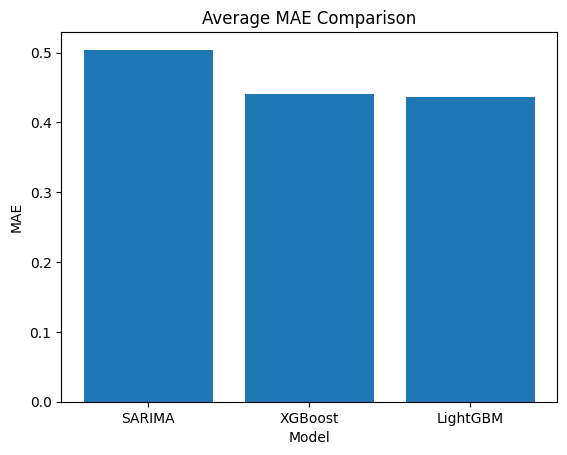

In [60]:
plt.figure()
plt.bar(summary["Model"], summary["Avg_MAE"])
plt.title("Average MAE Comparison")
plt.ylabel("MAE")
plt.xlabel("Model")
plt.show()


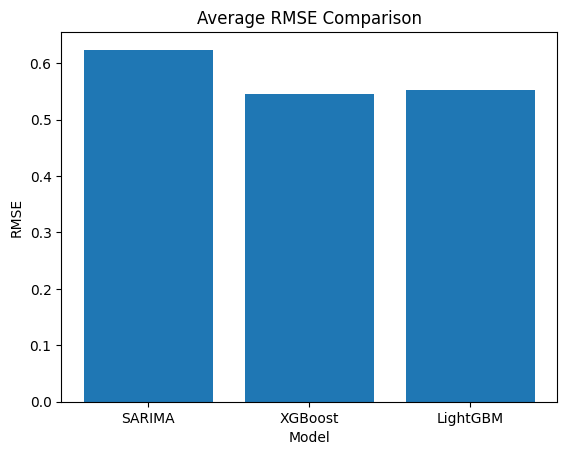

In [61]:
plt.figure()
plt.bar(summary["Model"], summary["Avg_RMSE"])
plt.title("Average RMSE Comparison")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.show()


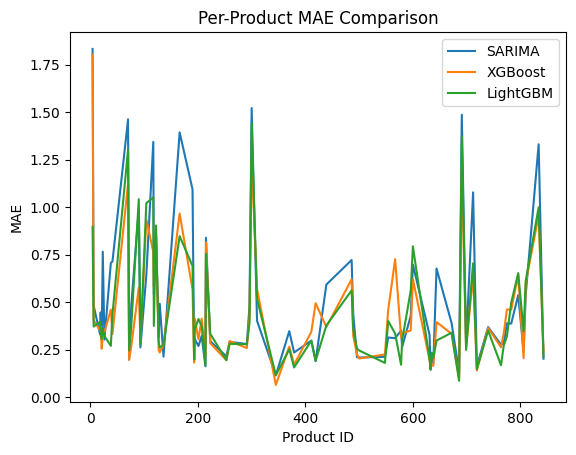

In [62]:
plt.figure()
plt.plot(comparison["product_id"], comparison["mae_sarima"], label="SARIMA")
plt.plot(comparison["product_id"], comparison["mae_xgb"], label="XGBoost")
plt.plot(comparison["product_id"], comparison["mae_lgbm"], label="LightGBM")
plt.xlabel("Product ID")
plt.ylabel("MAE")
plt.title("Per-Product MAE Comparison")
plt.legend()
plt.show()


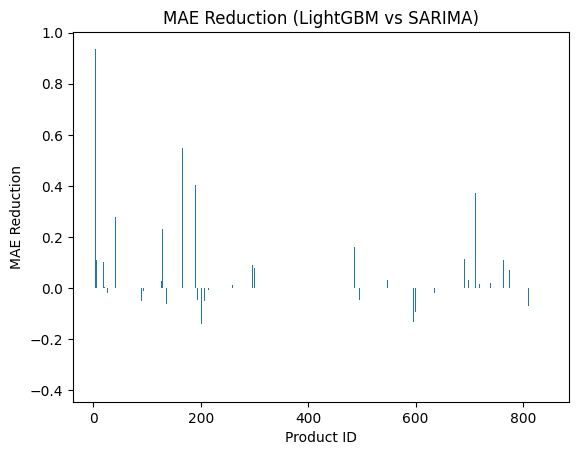

In [63]:
comparison["mae_reduction_vs_sarima"] = (
    comparison["mae_sarima"] - comparison["mae_lgbm"]
)

plt.figure()
plt.bar(comparison["product_id"], comparison["mae_reduction_vs_sarima"])
plt.title("MAE Reduction (LightGBM vs SARIMA)")
plt.xlabel("Product ID")
plt.ylabel("MAE Reduction")
plt.show()


**inventory reorder**

In [64]:
import pandas as pd
import numpy as np


In [65]:
pred_df = pd.read_csv("lightgbm_all_product_predictions.csv")


In [66]:
forecast_horizon = 14

forecast_summary = (
    pred_df
    .groupby("product_id")["predicted_sales"]
    .sum()
    .reset_index(name="forecast_demand_14d")
)

print(forecast_summary.head())


   product_id  forecast_demand_14d
0           4            18.809208
1           6            14.743942
2          18             4.368108
3          19            14.545222
4          21            12.477596


In [67]:
SAFETY_FACTOR = 1.20

forecast_summary["safety_stock"] = (
    forecast_summary["forecast_demand_14d"] * (SAFETY_FACTOR - 1)
)

forecast_summary["recommended_stock"] = (
    forecast_summary["forecast_demand_14d"] * SAFETY_FACTOR
)


In [68]:
forecast_summary["recommended_stock"] = (
    forecast_summary["recommended_stock"]
    .apply(lambda x: int(np.ceil(x)))
)



In [71]:
np.random.seed(42)

forecast_summary["current_stock"] = np.random.randint(
    0, 10, size=len(forecast_summary)
)


In [72]:
forecast_summary["reorder_qty"] = (
    forecast_summary["recommended_stock"]
    - forecast_summary["current_stock"]
)

forecast_summary["reorder_qty"] = (
    forecast_summary["reorder_qty"]
    .apply(lambda x: max(0, x))
)


In [73]:
reorder_table = forecast_summary[[
    "product_id",
    "forecast_demand_14d",
    "current_stock",
    "recommended_stock",
    "reorder_qty"
]]

print(reorder_table.head())


   product_id  forecast_demand_14d  current_stock  recommended_stock  \
0           4            18.809208              6                 23   
1           6            14.743942              3                 18   
2          18             4.368108              7                  6   
3          19            14.545222              4                 18   
4          21            12.477596              6                 15   

   reorder_qty  
0           17  
1           15  
2            0  
3           14  
4            9  


In [74]:
reorder_table.to_csv("inventory_reorder_plan.csv", index=False)


**DASHBOARD**

In [81]:
!pip install gradio


In [89]:
# ===================== INSTALL (run once in Colab) =====================
# !pip install gradio plotly pandas numpy

# ===================== IMPORTS =====================
import gradio as gr
import pandas as pd
import plotly.express as px
import numpy as np

# ===================== LOAD DATA =====================
sarima = pd.read_csv("sarima_product_metrics.csv")
xgb = pd.read_csv("xgboost_product_metrics.csv")
lgbm = pd.read_csv("lightgbm_product_metrics.csv")
reorder = pd.read_csv("inventory_reorder_plan.csv")

# ===================== MERGE METRICS =====================
comparison = (
    sarima.merge(xgb, on="product_id", suffixes=("_sarima", "_xgb"))
          .merge(lgbm, on="product_id")
          .rename(columns={"mae": "mae_lgbm", "rmse": "rmse_lgbm"})
)

comparison = comparison[[
    "product_id",
    "mae_sarima", "mae_xgb", "mae_lgbm",
    "rmse_sarima", "rmse_xgb", "rmse_lgbm"
]]

# ===================== SUMMARY STATS =====================
summary = pd.DataFrame({
    "Model": ["SARIMA", "XGBoost", "LightGBM"],
    "Avg MAE": [
        sarima["mae"].mean(),
        xgb["mae"].mean(),
        lgbm["mae"].mean()
    ],
    "Avg RMSE": [
        sarima["rmse"].mean(),
        xgb["rmse"].mean(),
        lgbm["rmse"].mean()
    ]
})

# ===================== HIGH-ERROR WARNINGS =====================
MAE_WARNING_THRESHOLD = summary["Avg MAE"].max() * 1.3

comparison["⚠️ High Error"] = comparison["mae_lgbm"] > MAE_WARNING_THRESHOLD
high_error_skus = comparison[comparison["⚠️ High Error"]]["product_id"].tolist()

# ===================== INVENTORY FLAGS =====================
LOW_STOCK_THRESHOLD = 3
reorder["STOCK_STATUS"] = np.where(
    reorder["current_stock"] <= LOW_STOCK_THRESHOLD,
    "🔴 LOW STOCK",
    "🟢 OK"
)

# ===================== AUTO SUMMARY TEXT =====================
def generate_summary():
    best_model = summary.sort_values("Avg MAE").iloc[0]["Model"]
    improvement = (
        (summary.loc[summary["Model"] == "SARIMA", "Avg MAE"].values[0] -
         summary.loc[summary["Model"] == "LightGBM", "Avg MAE"].values[0])
    )

    return f"""
### 📄 Auto-Generated Insight Summary

• **Best Model:** {best_model}
• **Average MAE Reduction vs SARIMA:** {improvement:.2f} units
• **High-Risk SKUs:** {len(high_error_skus)} products require attention
• **Inventory Impact:** {int(reorder['reorder_qty'].sum())} total units recommended for reorder

✅ **LightGBM provides the most stable and accurate forecasts for operational planning.**
"""

# ===================== DASHBOARD RENDER FUNCTION =====================
def render_dashboard(theme):

    plot_template = "plotly_dark" if theme == "Dark" else "plotly_white"

    # ---- MAE Plot with annotation ----
    mae_fig = px.bar(
        summary, x="Model", y="Avg MAE", color="Model",
        color_discrete_map={
            "SARIMA": "#7f7f7f",
            "XGBoost": "#1f77b4",
            "LightGBM": "#2ca02c"
        },
        title="Average MAE Comparison (Lower is Better)"
    )
    mae_fig.add_annotation(
        text="LightGBM achieves the lowest MAE",
        x="LightGBM",
        y=summary["Avg MAE"].min(),
        showarrow=True,
        arrowhead=2
    )
    mae_fig.update_layout(template=plot_template)

    # ---- RMSE Plot ----
    rmse_fig = px.bar(
        summary, x="Model", y="Avg RMSE", color="Model",
        color_discrete_map={
            "SARIMA": "#7f7f7f",
            "XGBoost": "#1f77b4",
            "LightGBM": "#2ca02c"
        },
        title="Average RMSE Comparison"
    )
    rmse_fig.update_layout(template=plot_template)

    # ---- Inventory Distribution ----
    reorder_fig = px.histogram(
        reorder, x="reorder_qty", nbins=20,
        title="Distribution of Inventory Reorder Quantities",
        color_discrete_sequence=["#ff7f0e"]
    )
    reorder_fig.update_layout(template=plot_template)

    return (
        mae_fig,
        rmse_fig,
        reorder_fig,
        comparison,
        reorder,
        generate_summary()
    )

# ===================== UI =====================
with gr.Blocks(theme=gr.themes.Soft()) as dashboard:

    gr.Markdown("# 📦 AI Demand Forecasting & Inventory Optimization Dashboard")

    gr.Markdown("""
**Objective:**
Compare multiple forecasting algorithms, justify the selection of **LightGBM**,
and translate predictions into **inventory reorder decisions**.
""")

    theme_toggle = gr.Radio(
        ["Light", "Dark"],
        value="Light",
        label="🌗 Dashboard Theme"
    )

    with gr.Row():
        gr.Markdown(f"### 🧮 Products Analyzed: **{reorder['product_id'].nunique()}**")
        gr.Markdown(f"### 📦 Total Units to Reorder: **{int(reorder['reorder_qty'].sum())}**")

    gr.Markdown("""
### 📌 Metric Tooltips
• **MAE:** Average daily forecast error
• **RMSE:** Penalizes large forecasting mistakes
• **Lower values indicate better model performance**
""")

    gr.Markdown("## 📊 Model Performance Comparison")
    mae_plot = gr.Plot()
    rmse_plot = gr.Plot()

    gr.Markdown("## 🔬 Per-Product Comparison (🟢 LightGBM highlighted)")
    comparison_table = gr.Dataframe(interactive=False)

    if len(high_error_skus) > 0:
        gr.Markdown(f"""
### 🟡 Warning: High-Error SKUs Detected
Products with unusually high forecasting error:
**{', '.join(map(str, high_error_skus[:10]))}{'...' if len(high_error_skus) > 10 else ''}**
""")

    gr.Markdown("## 📋 Inventory Reorder Table (🔴 = Immediate Action Required)")
    reorder_table = gr.Dataframe(interactive=False)

    gr.Markdown("## 📊 Inventory Insights")
    reorder_plot = gr.Plot()

    gr.Markdown("## 📄 Automated Decision Summary")
    summary_text = gr.Markdown()

    theme_toggle.change(
        fn=render_dashboard,
        inputs=theme_toggle,
        outputs=[
            mae_plot,
            rmse_plot,
            reorder_plot,
            comparison_table,
            reorder_table,
            summary_text
        ]
    )

dashboard.launch(share=True)


/tmp/ipython-input-76958142.py:131: DeprecationWarning:

The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.



Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8f2b84ad15a6f7d719.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
